In [3]:
import numpy as np
import pandas as pd
import sys
import re

sys.path.insert(0 , "../codes/")
import fantomDE
from viz import scatterPlot_colors

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import  LogNorm
from matplotlib.offsetbox import  AnchoredText
from IPython.core import display as ICD
%matplotlib inline
plt.rcParams["axes.labelsize"] = "x-large"
plt.rcParams["xtick.labelsize"] =  "x-large"
plt.rcParams["ytick.labelsize"] =  "x-large"

This notebook calls DE of TFs, chromatin remodelers and remaining genes in kcytes relative to other human primary cells

In [4]:
####################################
## Function Definitions 
def scatterPlot_DE( xvals ,yvals , pvals,ax ,reverseOrder = True, signifThresh = 0.1 ,
                   xLower = None, xUpper= None, yLower = None , yUpper = None,
                  title = "" ,  plotKwargs= {'alpha': 0.6}):
    
    
    colors = np.array( [ 'red' if pval < signifThresh else "black" for pval in pvals  ]  ) 
    nDE_genes = np.count_nonzero(pvals < signifThresh)
    
    finite_mask = np.isfinite(yvals)
    xvals = xvals[finite_mask].copy()
    yvals = yvals[finite_mask].copy()
    colors =  colors[finite_mask].copy()
    
    if reverseOrder :
        xvals = xvals[::-1] 
        yvals = yvals[::-1] 
        colors = colors[::-1]
    ax = scatterPlot_colors( xvals , yvals , colors,
                    ax = ax ,
                    xLower =  xLower, xUpper=  xUpper, yLower =  yLower , yUpper = yUpper, 
                   xlabel = "Mean expression Keratinocyte (tpm)" ,
                   ylabel = "log2 FC",
                   plotKwargs= plotKwargs , 
                   text = "FDR : {:.2f}\nnum DE genes : {:d}".format(signifThresh, nDE_genes),
                   title = title  )
        
    return ax

In [5]:
fi_fantomExpr ="./hg19.cage_peak_phase1and2combined_tpm_allEntrez-sum.tsv.gz"
fi_entrezToSymbol = "../raw/CAGEpeaks_geneSymbol-entrezID.txt"
fi_TFs = "../raw/Homo_sapiens_transcription_factors_gene_list-symb.txt"
fi_chromRemod = "../raw/Homo_sapiens_chromatin_remodeling_factors_gene_list-symb.txt"

fo_DE_TF = "fantomDE-TF_keratEpiderm-logFCMean-minExpr0-FDR0.05.stats.tsv"
fo_DF_allGenes = "fantomDE-allGenes_keratEpiderm-logFCMean-minExpr0-FDR0.05.stats.tsv"

In [6]:
fantomExpr = pd.read_csv(fi_fantomExpr ,sep = "\t" , index_col = 0, header = 0).transpose()
entrezToSymb_df = pd.read_csv(fi_entrezToSymbol, sep = "\t" , index_col = 1 )
TFs = pd.read_csv( fi_TFs , index_col= 0 , sep = "\t" ).index.values

### split fantomExpr into TFs , chromRemods and other Genes 

In [7]:
fantomExpr.rename(entrezToSymb_df.loc[: , "Gene_Symbol"] , axis = 1 , inplace = True )
## select TFs
TFs_inFantom =  [ x for x in TFs  if x in  fantomExpr.columns.values ] 
print("{} of the {} TFs are in fantomExpr".format( len(TFs_inFantom) , len(TFs) ))
fantomExpr_TFs = fantomExpr.loc[: ,TFs_inFantom ].copy()

1478 of the 1546 TFs are in fantomExpr


###  Call DE on the set of TFs

In [8]:
### Split into kerat. vs other
kerat_rows_all =  [x for x in fantomExpr_TFs.index.values if \
                   re.search('Keratinocyte',  x, re.IGNORECASE ) is not None ]
kerat_rows_epidermal =  [x for x in fantomExpr_TFs.index.values if \
                         re.search('Keratinocyte - epidermal',  x, re.IGNORECASE ) is not None ]
fantomExpr_TFs_kerat_epi = fantomExpr_TFs.loc[kerat_rows_epidermal , :].copy()
fantomExpr_TFs_other=  fantomExpr_TFs.loc[ ~ fantomExpr_TFs.index.isin(kerat_rows_all) ,  : ].copy()
print("comparing {} keratinocyte data sets to {} other data sets".format(fantomExpr_TFs_kerat_epi.shape[0] , 
                                                                        fantomExpr_TFs_other.shape[0]  ))

comparing 3 keratinocyte data sets to 491 other data sets


In [9]:
signifThresh = 0.05
logFC_min = 0.0
minExpr_kerat = 0.0

results_df = fantomDE.callDE_genes( group1_df  = fantomExpr_TFs_kerat_epi.copy(),
                                    group2_df  = fantomExpr_TFs_other.copy(), 
                                    group1Name = "keratinocyte" , group2Name = "other" ,
                                        signifThresh = signifThresh, 
                                        testName = "mannWhitneyU",
                                        testKwargs = {'progressUpdate': 1000 , 
                                                     "pAdj_method" :  "fdr_bh" ,
                                                    "alpha" : signifThresh,
                                                     "alternative" : "greater"},
                                        minGroup1_expr_mean = minExpr_kerat , minGroup2_expr_mean = None,
                                        minGroup1_expr_median = None , minGroup2_expr_median = None,
                                        minLog2FC_mean = logFC_min  , minLog2FC_median = None , 
                                        sortByLogFC_median = False)

nDE = np.count_nonzero( results_df.loc[: ,  "p_adj"] < signifThresh )
nExpressed = np.count_nonzero( results_df.loc[: , "avgExpr_keratinocyte"] >=  minExpr_kerat )

/home/apps/software/Anaconda3/5.1.0/lib/python3.6/site-packages/pandas/core/series.py:2354: RuntimeWarning: divide by zero encountered in log2
  new_values = map_f(values, arg)
/home/apps/software/Anaconda3/5.1.0/lib/python3.6/site-packages/pandas/core/series.py:2354: RuntimeWarning: divide by zero encountered in log2
  new_values = map_f(values, arg)


filtering on group1_expr_mean with minimum 0.0
filtering on  minLog2FC_mean with minimum 0.0
Excluding 1195 genes from DE test
Running DE test on 283 genes
comparing groups with test mannWhitneyU


In [11]:
results_df.to_csv(fo_DE_TF  + ".gz", sep = "\t" , compression= "gzip")

/home/apps/software/jupyter/1.0.0-IGB-gcc-4.9.4-Python-3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


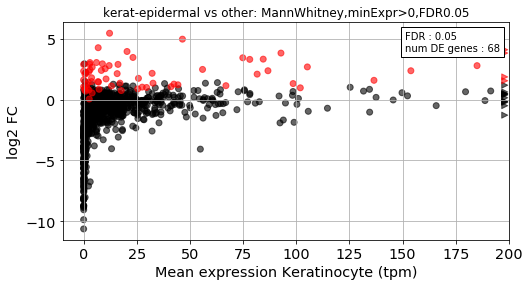

In [9]:
xUpper = 200
fig , ax = plt.subplots(figsize= (8,4) )
testName = "kerat-epidermal vs other: MannWhitney,minExpr>0,FDR0.05"

ax = scatterPlot_DE( xvals =  results_df.loc[: , "avgExpr_keratinocyte"].values  ,
                   yvals  = results_df.loc[ : , 'logFC'].values, 
                   pvals = results_df.loc[ : , 'p_adj'].values,
                   ax = ax,
                   reverseOrder = True, signifThresh =  signifThresh  ,
                   xLower = None, xUpper= xUpper, yLower = None , yUpper = None,
                    title = testName ,  plotKwargs= {'alpha': 0.6})

###  Call DE on the set of all genes

In [10]:
fantomExpr_allGenes = fantomExpr.loc[ : , entrezToSymb_df.loc[: , "Gene_Symbol"].values  ].copy()
print("There are {} named genes in fantomExpr".format(fantomExpr_allGenes.shape[1] ) )

There are 18950 named genes in fantomExpr


In [11]:
### Split into kerat. vs other
fantomExpr_kerat_epi = fantomExpr_allGenes.loc[kerat_rows_epidermal , :].copy()
fantomExpr_other=  fantomExpr_allGenes.loc[ ~ fantomExpr_allGenes.index.isin(kerat_rows_all) ,  : ].copy()

In [12]:
print("comparing {} keratinocyte data sets to {} other data sets".format(fantomExpr_kerat_epi.shape[0] , 
                                                                        fantomExpr_other.shape[0]  ))

comparing 3 keratinocyte data sets to 491 other data sets


In [13]:
logFC_min = 0.0
minExpr_kerat = 0.0
signifThresh = 0.05

results_df = fantomDE.callDE_genes( group1_df  = fantomExpr_kerat_epi.copy(),
                                    group2_df  = fantomExpr_other.copy(), 
                                    group1Name = "keratinocyte" , group2Name = "other" ,
                                        signifThresh = signifThresh, 
                                        testName = "mannWhitneyU",
                                        testKwargs = {'progressUpdate': 1000 , 
                                                     "pAdj_method" :  "fdr_bh" ,
                                                    "alpha" : signifThresh,
                                                     "alternative" : "greater"},
                                        minGroup1_expr_mean = minExpr_kerat , minGroup2_expr_mean = None,
                                        minGroup1_expr_median = None , minGroup2_expr_median = None,
                                        minLog2FC_mean = logFC_min, minLog2FC_median =  None, 
                                        sortByLogFC_median = False)

nDE = np.count_nonzero( results_df.loc[: ,  "p_adj"] < signifThresh )
nExpressed = np.count_nonzero( results_df.loc[: , "avgExpr_keratinocyte"] >=  minExpr_kerat )

/home/apps/software/Anaconda3/5.1.0/lib/python3.6/site-packages/pandas/core/series.py:2354: RuntimeWarning: divide by zero encountered in log2
  new_values = map_f(values, arg)


filtering on group1_expr_mean with minimum 0.0
filtering on  minLog2FC_mean with minimum 0.0
Excluding 14039 genes from DE test
Running DE test on 4911 genes
comparing groups with test mannWhitneyU
completed 1000 of 4911 tests
completed 2000 of 4911 tests
completed 3000 of 4911 tests
completed 4000 of 4911 tests


In [14]:
results_df.to_csv(fo_DF_allGenes+ ".gz", sep = "\t" , compression= "gzip")

/home/apps/software/jupyter/1.0.0-IGB-gcc-4.9.4-Python-3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


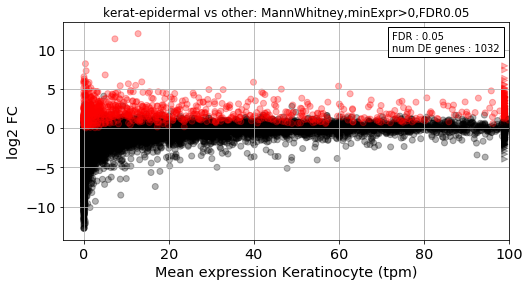

In [15]:
xUpper = 100
testName = "kerat-epidermal vs other: MannWhitney,minExpr>0,FDR0.05"
fig , ax = plt.subplots(figsize= (8,4) )


ax = scatterPlot_DE( xvals =  results_df.loc[: , "avgExpr_keratinocyte"].values  ,
                   yvals  = results_df.loc[ : , 'logFC'].values, 
                   pvals = results_df.loc[ : , 'p_adj'].values,
                   ax = ax,
                   reverseOrder = True, signifThresh =  signifThresh  ,
                   xLower = None, xUpper= xUpper, yLower = None , yUpper = None,
                    title = testName ,  plotKwargs= {'alpha': 0.3})